In [1]:
import torch
import torch.nn as nn
import numpy as np
import pandas as pd
from sklearn.model_selection import KFold, train_test_split
import matplotlib.pyplot as plt
import os
device = 'cuda' if torch.cuda.is_available() else 'cpu'
device

'cuda'

In [2]:
train_dataset_path = 'dataset/train'
all_subjects = sorted(os.listdir(train_dataset_path))

data_frames = []
target_data_frames = []

for subject_folder in all_subjects:
    subject_path = os.path.join(train_dataset_path, subject_folder)
    
    if os.path.isdir(subject_path):
        csv_files = sorted([f for f in os.listdir(subject_path) if f.endswith('.csv')])
        
        if len(csv_files) >= 2:
            first_csv = csv_files[0]
            target_csv = csv_files[4]
            # Input signal
            full_path = os.path.join(subject_path, first_csv)
            df = pd.read_csv(full_path, header=None).T
            data_frames.append(df)
            
            # Target values
            target_val_path = os.path.join(subject_path, target_csv)
            target_df = pd.read_csv(target_val_path, header=None).T
            target_df = target_df.drop(index=0).reset_index(drop=True)  # drop first row
            target_data_frames.append(target_df)

# Combine all subject data
train_data_full = pd.concat(data_frames, ignore_index=True)

target_values = pd.concat(target_data_frames, ignore_index=True)


In [3]:
print(train_data_full.shape)
train_data_full.head()


(46, 54240)


,0,1,2,3,4,5,6,7,8,9,...,54230,54231,54232,54233,54234,54235,54236,54237,54238,54239
0,517,519,520,520,520,519,517,513,509,502,...,484,481,484,470,467,470,466,462,458,464
1,504,503,506,506,508,508,511,514,516,517,...,464,469,477,487,493,502,512,522,525,534
2,488,489,487,487,486,484,484,484,484,486,...,271,256,245,240,239,239,239,244,248,259
3,646,652,652,653,650,645,637,626,616,604,...,525,524,524,524,525,522,520,521,521,521
4,467,469,467,472,469,471,476,479,482,484,...,482,479,475,471,468,464,464,460,459,458


In [4]:
print(target_values.shape)
target_values.head()

(46, 240)


,0,1,2,3,4,5,6,7,8,9,...,230,231,232,233,234,235,236,237,238,239
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


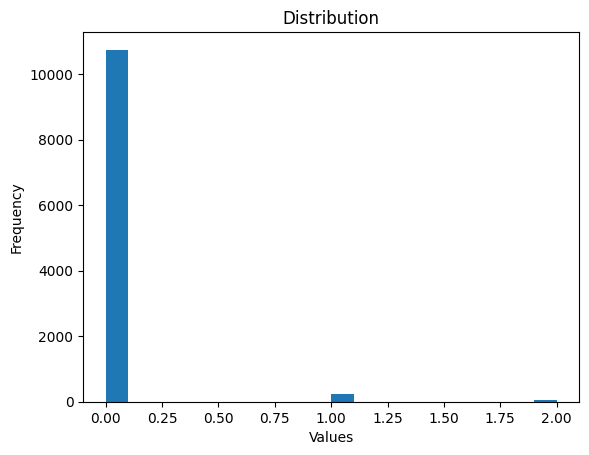

In [5]:
import matplotlib.pyplot as plt

plt.hist(target_values.values.flatten(), bins=20)
plt.title("Distribution")
plt.xlabel("Values")
plt.ylabel("Frequency")
plt.show()


In [6]:
total_ones = target_values.values.sum()
print("Total number of ones in dataset:", total_ones)


Total number of ones in dataset: 351


In [7]:
non_zero_rows = (target_values.sum(axis=1) > 0).sum()
print(f"{non_zero_rows} out of {target_values.shape[0]} samples have at least one positive label.")


24 out of 46 samples have at least one positive label.


In [8]:
class LSTM(nn.Module):
    def __init__(self, n_hidden=512):
        super(LSTM, self).__init__()
        self.lstm = nn.LSTM(input_size=226, hidden_size=n_hidden, batch_first=True)
        self.linear = nn.Linear(n_hidden, 1)  # One output per timestep

    def forward(self, x):
        # x: [batch, 240, 226]
        lstm_out, _ = self.lstm(x)  # [batch, 240, n_hidden]
        logits = self.linear(lstm_out).squeeze(-1)  # [batch, 240]
        return logits  # raw logits (use BCEWithLogitsLoss)


In [9]:
class MovementDataset(torch.utils.data.Dataset):
    def __init__(self, data, targets):
        self.data = data  # shape: [n_subjects, 240*226]
        self.targets = targets  # shape: [n_subjects, 240]

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        # reshape signal into [240, 226]
        signal = self.data.iloc[idx].values.astype(np.float32).reshape(240, 226)
        signal = torch.tensor(signal)  # [240, 226]

        target = self.targets.iloc[idx].values.astype(np.float32)  # [240]
        target = torch.tensor(target)  # [240]

        return signal, target


In [10]:
from sklearn.model_selection import train_test_split

# Split both data and target labels
traindata, valdata, train_targets, val_targets = train_test_split(
    train_data_full, target_values, test_size=0.16, random_state=42
)

# Create datasets using corresponding targets
train_dataset = MovementDataset(traindata, train_targets)
val_dataset = MovementDataset(valdata, val_targets)

# DataLoaders
train_dataloader = torch.utils.data.DataLoader(train_dataset, batch_size=1)
val_dataloader = torch.utils.data.DataLoader(val_dataset, batch_size=1)


In [11]:
from torch.nn import BCEWithLogitsLoss
import torch

class FocalLoss(torch.nn.Module):
    def __init__(self, alpha=1.0, gamma=2.0, reduction='mean'):
        super().__init__()
        self.alpha = alpha
        self.gamma = gamma
        self.reduction = reduction
        self.bce = BCEWithLogitsLoss(reduction='none')

    def forward(self, inputs, targets):
        bce_loss = self.bce(inputs, targets)
        pt = torch.exp(-bce_loss)  # pt = 1 - p_t
        focal_loss = self.alpha * (1 - pt) ** self.gamma * bce_loss
        return focal_loss.mean() if self.reduction == 'mean' else focal_loss.sum()


In [12]:
from sklearn.metrics import f1_score
import torch
import numpy as np

def train(model, lossfn, optimizer, scheduler, device, train_dataloader, val_dataloader, epochs=50, threshold=0.5):
    model.to(device)

    for epoch in range(epochs):
        model.train()
        print(f"\nEpoch {epoch + 1}/{epochs}")
        all_preds = []
        all_trues = []

        epoch_loss = 0.0

        for t, (xb, yb) in enumerate(train_dataloader):
            xb = xb.to(device, dtype=torch.float32)  # [batch, 240, 226]
            yb = yb.to(device, dtype=torch.float32)  # [batch, 240]

            logits = model(xb)  # Output: [batch, 240]
            loss = lossfn(logits, yb)

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            epoch_loss += loss.item()

            preds_binary = (torch.sigmoid(logits) > threshold).int().cpu().numpy()
            yb_cpu = yb.int().cpu().numpy()

            all_preds.append(preds_binary)
            all_trues.append(yb_cpu)

        # Compute F1 score (train)
        all_preds = np.concatenate(all_preds, axis=0).flatten()
        all_trues = np.concatenate(all_trues, axis=0).flatten()
        f1_micro = f1_score(all_trues, all_preds, average='micro', zero_division=0)

        print(f"Train Loss: {epoch_loss:.4f} | Train F1 : {f1_micro:.4f}  | Unique preds: {np.unique(all_preds)}")
        scheduler.step(loss)

        # --- Validation ---
        model.eval()
        all_preds = []
        all_trues = []
        val_loss = 0.0

        with torch.no_grad():
            for xv, yv in val_dataloader:
                xv = xv.to(device, dtype=torch.float32)
                yv = yv.to(device, dtype=torch.float32)

                logits = model(xv)
                loss = lossfn(logits, yv)
                val_loss += loss.item()

                preds_binary = (torch.sigmoid(logits) > threshold).int().cpu().numpy()
                yv_cpu = yv.int().cpu().numpy()

                all_preds.append(preds_binary)
                all_trues.append(yv_cpu)

        all_preds = np.concatenate(all_preds, axis=0).flatten()
        all_trues = np.concatenate(all_trues, axis=0).flatten()
        f1 = f1_score(all_trues, all_preds, average='micro', zero_division=0)

        print(f"Val Loss: {val_loss:.4f} | Val F1 : {f1:.4f} | Unique preds: {np.unique(all_preds)}")



In [17]:
# Define the model
model = LSTM()  # Assumes input [batch, 240, 226] and output [batch, 240]

# Calculate class balance
pos = np.sum(train_targets.values)
neg = np.prod(train_targets.shape) - pos
pos_weight = torch.tensor([neg / pos]).to(device)

lossfn = torch.nn.BCEWithLogitsLoss(pos_weight=pos_weight)


# Optimizer with a small learning rate (recommended for LSTM)
optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)

# Scheduler to reduce LR if val loss plateaus
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(
    optimizer,
    mode='min',          # watch validation loss
    patience=7,          # wait 7 epochs before reducing
    factor=0.5,          # halve the LR
    eps=1e-11            # minimal LR change
)


In [18]:
train(
    model=model,
    lossfn=lossfn,
    optimizer=optimizer,
    scheduler=scheduler,
    device=device,
    train_dataloader=train_dataloader,
    val_dataloader=val_dataloader,
    epochs=50,           # or more depending on your need
    threshold=0.5
)



Epoch 1/50
Train Loss: 2.1234 | Train F1 : 0.9473  | Unique preds: [0 1]
Val Loss: 0.6249 | Val F1 : 0.9542 | Unique preds: [0]

Epoch 2/50
Train Loss: 1.8802 | Train F1 : 0.9769  | Unique preds: [0]
Val Loss: 0.6814 | Val F1 : 0.9542 | Unique preds: [0]

Epoch 3/50
Train Loss: 1.9277 | Train F1 : 0.9769  | Unique preds: [0]
Val Loss: 0.6656 | Val F1 : 0.9542 | Unique preds: [0]

Epoch 4/50
Train Loss: 1.8416 | Train F1 : 0.9769  | Unique preds: [0]
Val Loss: 0.6407 | Val F1 : 0.9542 | Unique preds: [0]

Epoch 5/50
Train Loss: 1.7566 | Train F1 : 0.9769  | Unique preds: [0]
Val Loss: 0.5946 | Val F1 : 0.9542 | Unique preds: [0]

Epoch 6/50
Train Loss: 1.7191 | Train F1 : 0.9769  | Unique preds: [0]
Val Loss: 0.5786 | Val F1 : 0.9542 | Unique preds: [0]

Epoch 7/50
Train Loss: 1.6196 | Train F1 : 0.9769  | Unique preds: [0]
Val Loss: 0.5395 | Val F1 : 0.9542 | Unique preds: [0]

Epoch 8/50
Train Loss: 1.5940 | Train F1 : 0.9769  | Unique preds: [0]
Val Loss: 0.5273 | Val F1 : 0.9542 | 